<a href="https://colab.research.google.com/github/busrasabakk/busrasabak/blob/master/BananaRepublicForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/municipality_bus_utilization (1).csv')  
print('dataset shape: ', data.shape)
data.head()


dataset shape:  (13070, 4)


,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019


In [14]:

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        13070 non-null  datetime64[ns]
 1   municipality_id  13070 non-null  int64         
 2   usage            13070 non-null  int64         
 3   total_capacity   13070 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 510.5 KB


In [4]:

data.isnull().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [16]:

def display_percent_missing(data):
    percent_missing = data.isnull().sum() *100 / len(data)
    missing_value_df = pd.DataFrame({'column_name': data.columns, 
                                     'percent_missing': percent_missing})
    
    display(missing_value_df.sort_values(by='percent_missing', ascending=False).head(25))
    return(missing_value_df)

In [17]:


missing_values= display_percent_missing(data)

,column_name,percent_missing
timestamp,timestamp,0.0
municipality_id,municipality_id,0.0
usage,usage,0.0
total_capacity,total_capacity,0.0


#Missing Values fixed

In [19]:

data['municipality_id'].fillna(0, inplace=True) # Uniq value filling 0
data['usage'].fillna(data['usage'].mode().iloc[0], inplace=True)  
data['total_capacity'].fillna(data['total_capacity'].mode().iloc[0], inplace=True)


In [21]:
categorical_columns=data.select_dtypes(include=['object','category','datetime'])
list(categorical_columns)

['timestamp']

In [22]:

numerical_columns=data.select_dtypes(exclude=['object','category','datetime'])
list(numerical_columns)


['municipality_id', 'usage', 'total_capacity']

In [7]:

# aggregation for duplicated hours, keys are timestamp and municipality_id
hourly_data = data.groupby([pd.Grouper(key="timestamp", freq="H"), pd.Grouper("municipality_id")]).usage.max().reset_index()
hourly_data.head()


,timestamp,municipality_id,usage
0,2017-06-04 07:00:00,0,204
1,2017-06-04 07:00:00,1,129
2,2017-06-04 07:00:00,2,273
3,2017-06-04 07:00:00,3,623
4,2017-06-04 07:00:00,4,1090


#Data Preprocessing and Visualization , Normalization and Models

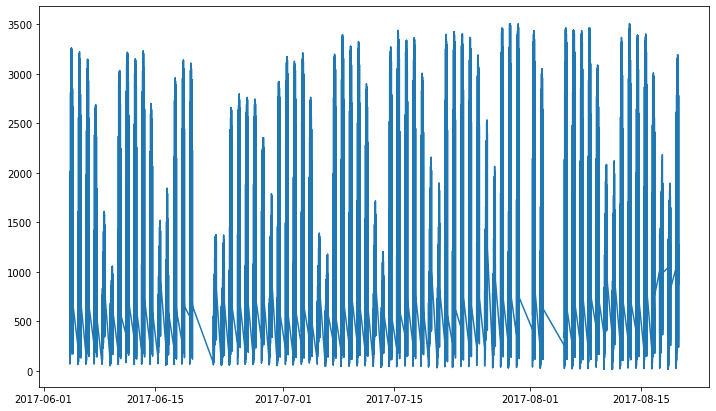

In [9]:

plt.figure(figsize=(12,7))
plt.plot(hourly_data.timestamp, hourly_data.usage)
plt.show()

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [25]:

hourly_df = data.groupby([pd.Grouper(key='timestamp', freq='60Min'), 'municipality_id', 'total_capacity']).max()
hourly_df = hourly_df.reset_index() 
hourly_df.set_index('timestamp', inplace=True)


In [26]:

hourly_df


,municipality_id,total_capacity,usage
timestamp,,,
2017-06-04 07:00:00,0,2813,204
2017-06-04 07:00:00,1,397,129
2017-06-04 07:00:00,2,697,273
2017-06-04 07:00:00,3,1930,623
2017-06-04 07:00:00,4,3893,1090
...,...,...,...
2017-08-19 16:00:00,5,587,239
2017-08-19 16:00:00,6,3113,1727
2017-08-19 16:00:00,7,2019,1450


In [28]:
df_plot = hourly_df.copy()


In [29]:


df_plot['date'] = df_plot.index
df_plot['hour'] = df_plot['date'].dt.hour
df_plot['dayofweek'] = df_plot['date'].dt.dayofweek
df_plot['quarter'] = df_plot['date'].dt.quarter
df_plot['month'] = df_plot['date'].dt.month
df_plot['year'] = df_plot['date'].dt.year
df_plot['dayofyear'] = df_plot['date'].dt.dayofyear
df_plot['dayofmonth'] = df_plot['date'].dt.day
df_plot['weekofyear'] = df_plot['date'].dt.isocalendar().week


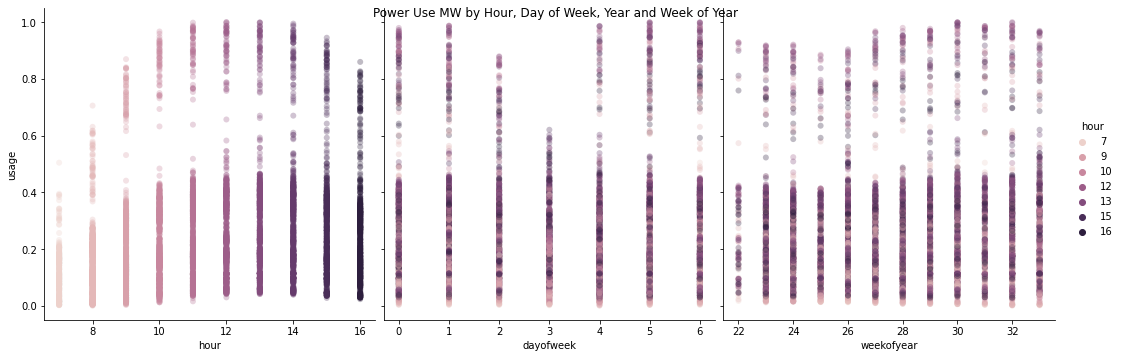

In [31]:
sns.pairplot(df_plot.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek','weekofyear'],
             y_vars='usage',
             height=5,
             plot_kws={'alpha':0.30, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()


In [32]:
def normalize_data(data):
    scaler = MinMaxScaler()
    data['usage']=scaler.fit_transform(data['usage'].values.reshape(-1,1))
    return data

hourly_df = normalize_data(hourly_df)


In [34]:

train_df = pd.concat([hourly_df[(hourly_df.index <= '2017-08-04')]])
test_df = hourly_df[(hourly_df.index > '2017-08-04')]


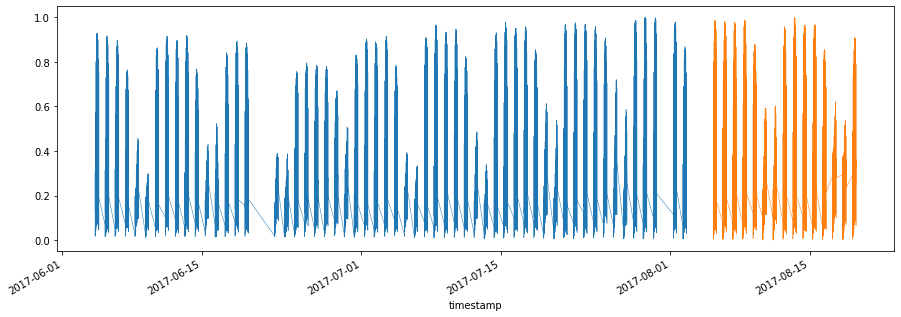

In [36]:

train_df['usage'].plot(linewidth=0.5, figsize=(15, 5));
test_df['usage'].plot(linewidth=0.5, figsize=(15, 5));


In [37]:

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


In [38]:

y_train = train_df['usage']
X_train = train_df.drop(['usage'], axis = 1)
y_test = test_df['usage']
X_test = test_df.drop(['usage'], axis = 1)


In [39]:
def plot_compare_pred(y_pred, y_true, name):
    """
    Plot in red color the predicted data and in green color the
    actual data to verify visually the accuracy of the model.
    """
    fig_verify = plt.figure(figsize=(30, 10))
    plt.plot(y_pred, color="red")
    plt.plot(y_true, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig(name + ".png")
    plt.close()

[12:04:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB: Score: 0.101743


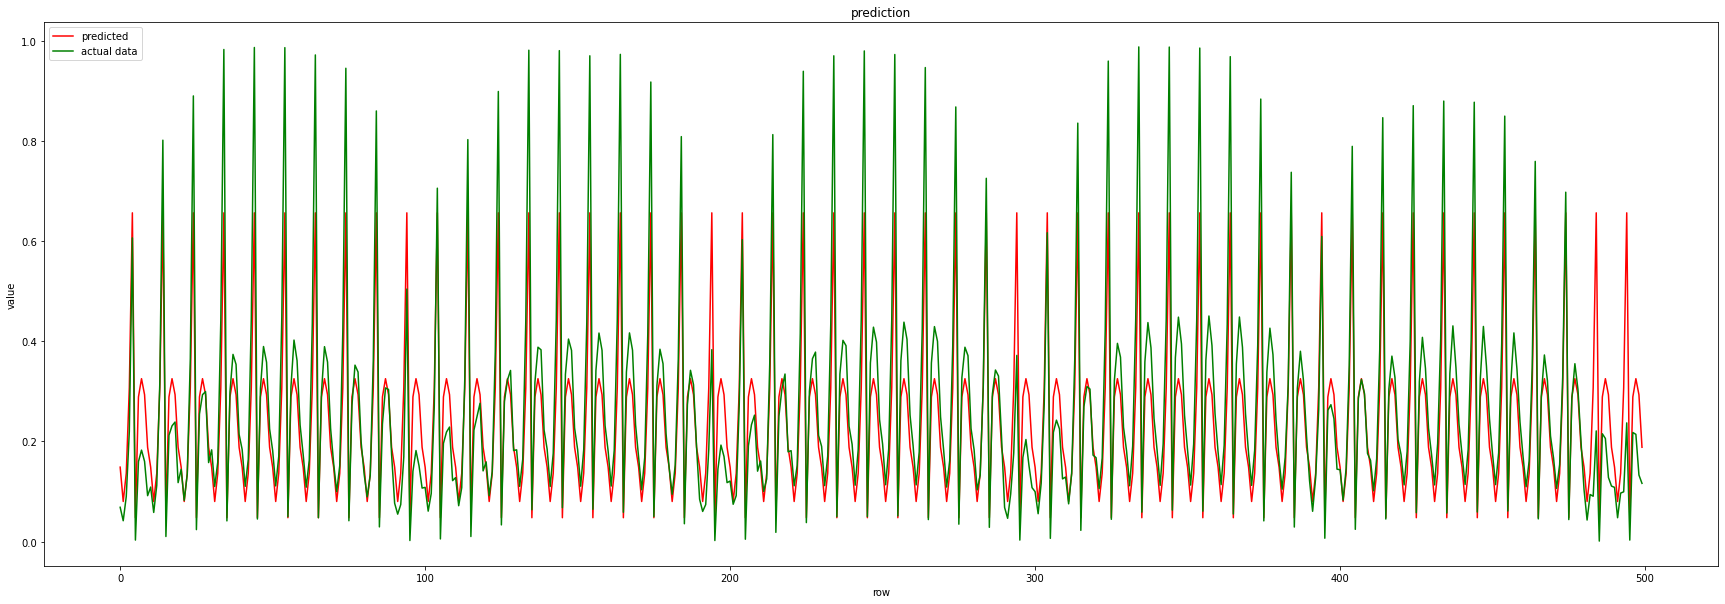

LR: Score: 0.146155


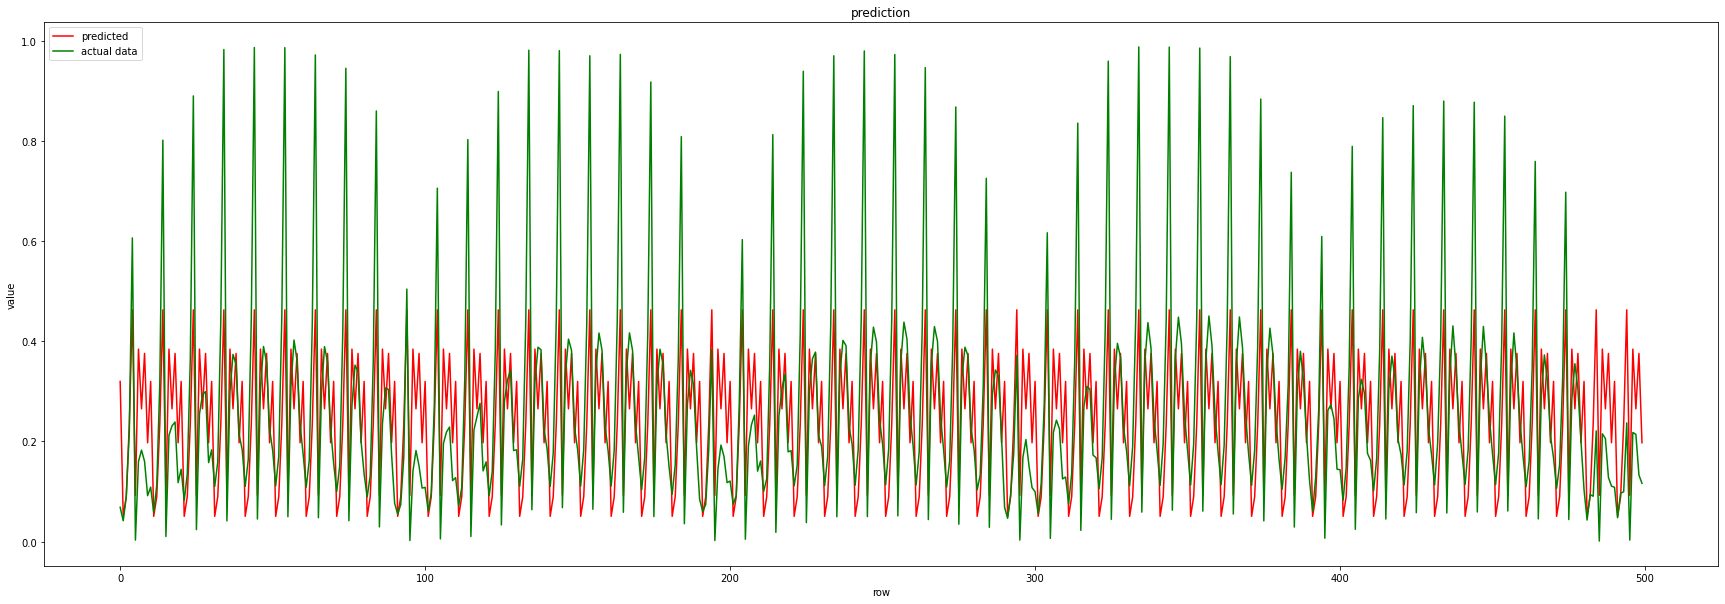

NN: Score: 0.149070


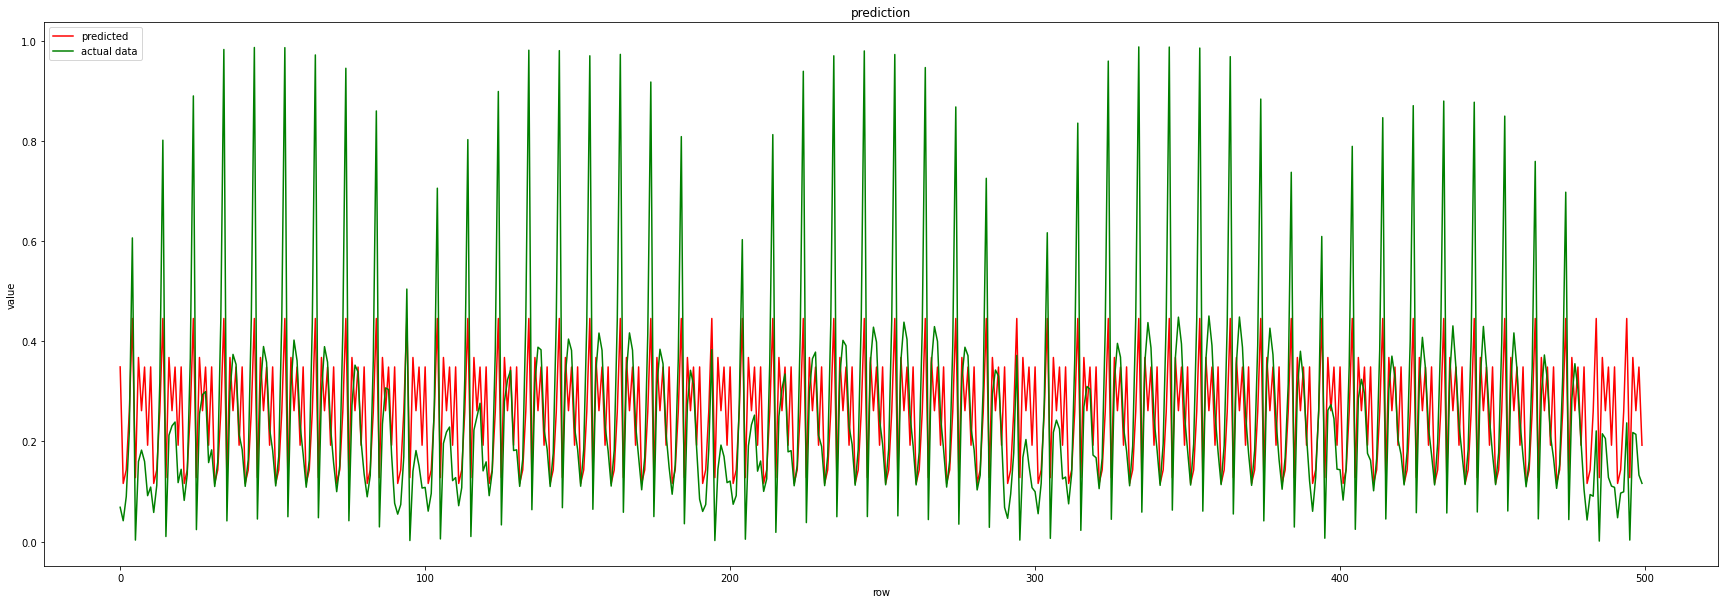

RF: Score: 0.101547


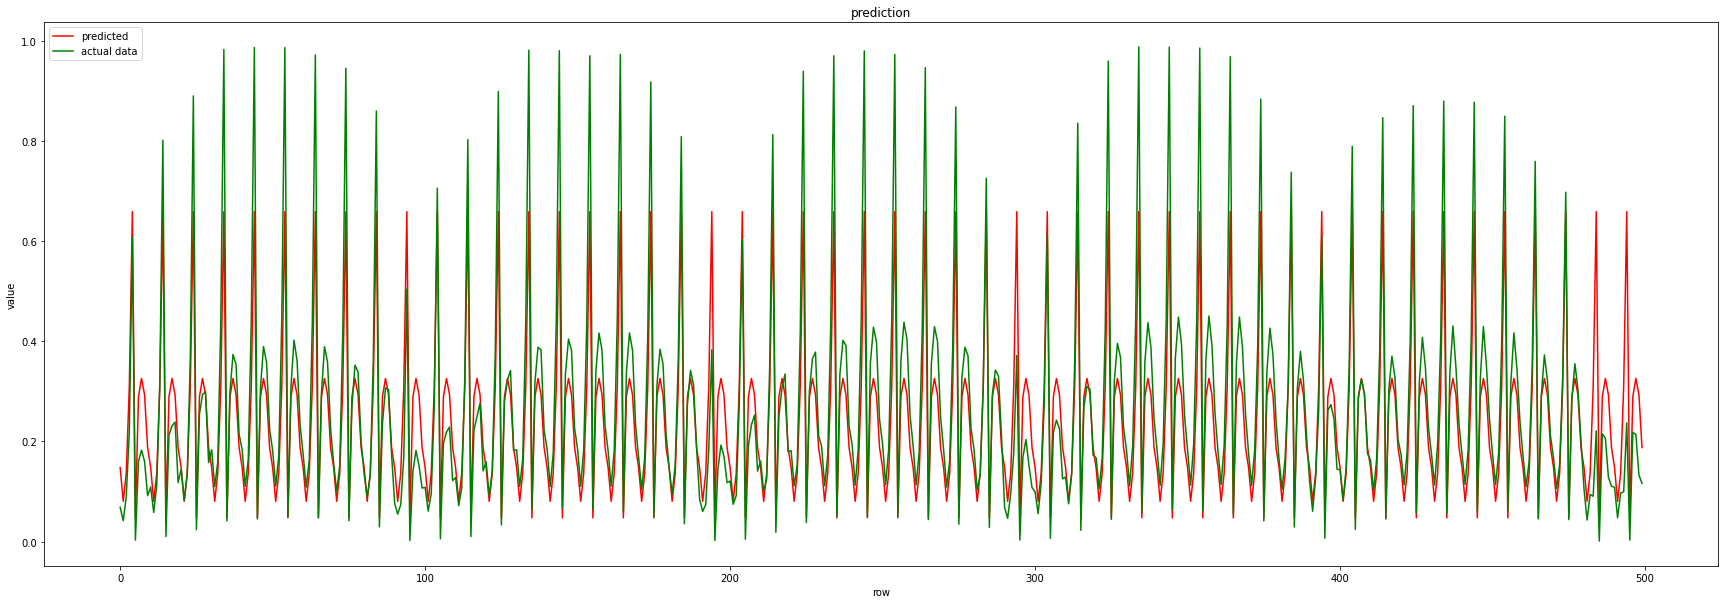

In [40]:

models = []
models.append(('XGB', XGBRegressor()))
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  
models.append(('RF', RandomForestRegressor(n_estimators = 10))) 

# Evaluate each model in turn
results = {}
for name, model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = mean_squared_error(y_true = y_test, y_pred=pred, squared=False)
    results[name]= score
    print('%s: Score: %f' % (name, score))
    
    plot_compare_pred(pred[:500], list(y_test.values)[:500], name)
